In [3]:
!pip install fireducks >>None

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import os
from datetime import datetime as dt

from scipy import stats
from scipy.stats import zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  

## Weather parser

- http://www.pogodaiklimat.ru/weather.php?id=28367 - Тюмень
- id=27612 - Москва
- id=29570 - Красноярск
- id=25913 - Магадан
- id=24959 - Якутск
- id=30710 - Иркутск
- id=29638 - Новосибирск
- id=34730 - Ростов
- id=28440 - Екатеринбург
- id=26702 - Калининград
- id=26063 - Санкт-Петербург
- id=28900 - Самара
- id=31735 - Хабаровск
- id=33955 - Симферополь

In [ ]:
# put your own months and year
year = 2025
months = range(1, 12)

def date_extractor(dates_list):
    days = []
    times = []
    merged_datetime = []
    for idx, item in enumerate(dates_list, start=1):
        if idx % 2 == 0:
            days.append(f'{year}.' + item.text)
        else:
            times.append(item.text)
    for idx, day_ in enumerate(days):
        time_ = times[idx]
        string = f"{day_} {time_}"

        datetime_object = datetime.strptime(string, '%Y.%d.%m %H')
        merged_datetime.append(datetime_object)

    return merged_datetime

def main_table_extractor(table_strings):
    merged_table = []
    for i in table_strings:
        x = i.findAll('td')
        for target_string in x:
            if target_string.text == '':
                merged_table.append(None)

            else:
                txt = target_string.text
                merged_table.append(txt)

    return merged_table

def build_values_table(cols, values):
    single_table_values = []
    n_iters = int(len(values) / len(cols))
    for i in range(n_iters):
        start_idx = 0 + len(cols) * i
        end_idx = len(cols) + len(cols) * i
        single_table_values.append(values[start_idx:end_idx])

    return single_table_values


def merge_data_and_table(data, table):
    for string_idx, string in enumerate(table):
        table[string_idx].insert(0, data[string_idx].strftime('%Y.%d.%m %H'))

    return table

def build_csv(cols, values):
    df = pd.DataFrame(values, columns=[cols])
    current_dir = os.getcwd()
    os.chdir(os.path.join(current_dir, "/kaggle/working/"))
    df.to_csv(f'Weather_{year}_{months}.csv', index=False)

def is_leap_year(year):
    if year % 4 != 0:
        return False
    elif year % 100 != 0:
        return True
    elif year % 400 != 0:
        return False
    else:
        return True

main_merged_table_values = []

for target_month_idx in months:
    start_day = 1
    if target_month_idx in [4, 6, 9, 11]:
        end_day = 30
    elif target_month_idx == 2:
        if is_leap_year(year):
            end_day = 29
        else:
            end_day = 28
    else:
        end_day = 31

    # Example = Moscow
    weather_url = f'http://www.pogodaiklimat.ru/weather.php?id=27612&bday={start_day}&fday={end_day}&amonth={target_month_idx}&ayear={year}&bot=2'
    r = requests.get(weather_url)
    soup = BeautifulSoup(r.content, 'lxml')

    # EXTRACT TIME AND DATE
    day_time = soup.find("div", class_="archive-table-left-column").findAll("td", class_="black")
    all_table_dates = date_extractor(day_time)

    # EXTRACT MAIN TABLE WITH VALUES
    table_strings = soup.select(
        'body > div.background-wrap > main > div > div > div > div > div > div:nth-child(5) > div.big-blue-billet > div > div.archive-table > div.archive-table-wrap > table')

    merged_table = main_table_extractor(table_strings)

    # BUILD FINAL TABLE FOR TARGET MONTH
    col_names = merged_table[:17]  # cut col names
    col_names.insert(0, 'wind_dir')
    col_names[1] = 'wind_speed'
    col_values = merged_table[17:]

    single_table_values = build_values_table(col_names, col_values)
    single_month_table = merge_data_and_table(all_table_dates, single_table_values)
    for row in single_month_table:
        main_merged_table_values.append(row)

col_names.insert(0, 'date')

build_csv(col_names, main_merged_table_values)

## Weather formater

- Ветер - указаны скорость ветра в м/с - средняя за 10 мин, порывы в срок и между сроками (в фигурных скобках) и направление, откуда дует ветер: С - северный, CВ - северо-восточный, В - восточный, ЮВ - юго-восточный, Ю - южный, ЮЗ - юго-западный, З - западный, СЗ - северо-западный.
- Видимость - горизонтальная дальность видимости в метрах или километрах. При видимости от 1 до 10 км при отсутствии осадков обычно наблюдается дымка, при ухудшении видимости до 1 км и менее - туман. В сухую погоду видимость может ухудшаться дымом, пылью или мглою.
- Явления - указаны атмосферные явления, наблюдавшиеся в срок или в последний час перед сроком; фигурными скобками обозначены явления, наблюдавшиеся между сроками (за 1-3 часа до срока); квадратными скобками обозначены град или гололедные отложения с указанием их диаметра в мм.
- Облачность - указаны через наклонную черту общая и нижняя облачность в баллах и высота нижней границы облаков в метрах; квадратными скобками обозначены формы облаков: Ci - перистые, Cs - перисто-слоистые, Cc - перисто-кучевые, Ac - высококучевые, As - высокослоистые, Sc - слоисто-кучевые, Ns - слоисто-дождевые, Cu - кучевые, Cb - кучево-дождевые. Подробнее классификацию облаков см. в Атласе облаков (PDF).
- T - Температура воздуха - температура, измеренная на высоте 2 м над землей.
- Td - Температура точки росы - температура, при понижении до которой содержащийся в воздухе водяной пар достигнет насыщения.
- f - Относительная влажность воздуха - влажноcть воздуха, измеренная на высоте 2 м над землей.
- Te - Эффективная температура - температура, которую ощущает одетый по сезону человек в тени. Характеристика душности погоды. При расчете учитывается влияние влажности воздуха и скорости ветра на теплоощущения человека.
- Tes - Эффективная температура на солнце - температура, которую ощущает человек, с поправкой на солнечный нагрев. Характеристика знойности погоды. Зависит от высоты солнца над горизонтом, облачности и скорости ветра. Ночью, в пасмурную погоду, а также при ветре 12 м/с и более поправка равна нулю.
- P - Атмосферное давление - приведенное к уровню моря атмосферное давление.
- Po - Атмосферное давление - измеренное на уровне метеостанции атмосферное давление.
- Tmin - Минимальная температура - минимум температуры воздуха на высоте 2 м над землей.
- Tmax - Максимальная температура - максимум температуры воздуха на высоте 2 м над землей.
- R - Количество осадков - Количество выпавших осадков за период времени, мм. При наведении курсора мыши на число - период времени, за который выпало указанное количество осадков.
- R24 - Количество осадков - Количество выпавших осадков за 24 часа, мм.
- S - Снежный покров - Высота снежного покрова, см. При наведении курсора мыши на число - состояние снежного покрова и степень покрытия местности в баллах.


In [ ]:
def formate_weather_csv(year):
    #year = dt.now().year
    #month = dt.now().month
    path_weather = f'/kaggle/working/Weather_{year}_range(1, 12).csv'

    df_weather = pd.read_csv(path_weather)
    print(df_weather.head(5).T)
    print(df_weather.shape)

    # Перевод названия колонок в нижний формат
    df_weather.columns = df_weather.columns.str.lower()

    # Словарь для переименования колонок
    new_column_names = {'видим.': 'vision', 'явления': 'phenomen', 'облачность': 'cloudy',
                        'т(с)': 't_c', 'тd(с)': 'td_с', 'f(%)': 'f_%', 'тe(с)': 'te_c',
                        'тes(с)': 'tes_c', 'комфортность': 'conformity', 'p(гпа)': 'p_gpa',
                        'po(гпа)': 'po_gpa', 'тmin(с)': 't_min_c', 'tmax(с)': 't_max_c',
                        'r(мм)': 'r_mm', 'r24(мм)': 'r_24_mm', 's(см)': 's_cm'}

    df_weather.rename(columns=new_column_names, inplace=True)

    # Перевод названия колонок в нижний формат
    df_weather.columns = df_weather.columns.str.lower()

    # Формируем словарь для s_cm
    cols_to_remove_r24 = ['r_24_mm']

    # Формируем словарь для остальных пропусков
    cols_to_remove_all = ['phenomen', 't_min_c', 't_max_c', 'r_mm', 's_cm']

    # Убираем колонку s_cm
    df_weather = df_weather.drop(cols_to_remove_r24, axis=1)

    # формируем чистый датасет
    df_weather = df_weather.drop(cols_to_remove_all, axis=1)

    # Создание пустой колонки time
    df_weather['time'] = pd.Series()

    # Создание пустой колонки vision_distance
    df_weather['vision_distance'] = pd.Series()

    # Создание пустой колонки vision_ruller
    df_weather['vision_ruller'] = pd.Series()

    # Создание пустой колонки cloudy_general
    df_weather['cloudy_general'] = pd.Series()

    # Создание пустой колонки cloudy_low
    df_weather['cloudy_low'] = pd.Series()

    # Создание пустой колонки cloudy_border
    df_weather['cloudy_border'] = pd.Series()

    # Создание пустой колонки cloudy_type
    df_weather['cloudy_type'] = pd.Series()

    # разобьем колонки на составляющие date
    df_weather['date'] = df_weather['date'].str[:-2]

    # Определяем длину датафрейма
    length = len(df_weather)

    # Создаем список значений, который будет циклически повторяться
    values = list(range(0, 22, 3))

    # Заполняем колонку "Значения" с использованием спискового выражения и оператора %
    df_weather["time"] = [values[i % len(values)] for i in range(length)]

    # Удаление фигурных скобок и содержимого в них в колонке
    df_weather['wind_speed'] = df_weather['wind_speed'].str.replace(r'\{.*?\}', '', regex=True)

    # перенос наименований в новый столбец
    df_weather['vision_distance'] = df_weather['vision'].str.replace('\d+', '')

    # перенос новых значений для цифр
    df_weather['vision'] = df_weather['vision'].str.extract('(\d+)', expand=False)

    # конвертация из типа object в тип float
    df_weather['vision'] = df_weather['vision'].astype(float)

    # Преобразовываем числа в строки, убираем три нуля и берем первый символ
    def modify_number(number):
        if number >= 1000:
            return int(str(number)[:1])
        else:
            return number

    df_weather['vision'] = df_weather['vision'].apply(modify_number)

    # функция кодировки уникальных значений
    def code_unique(dataset, column):
        unique_values = dataset[column].unique()
        unique_dict = {value: index for index, value in enumerate(unique_values)}
        return unique_dict

    # печать словаря по conformity
    dict_conformity = code_unique(df_weather, 'conformity')

    # Замена значений по словарю conformity
    df_weather['conformity'] = df_weather['conformity'].replace(dict_conformity)

    # печать словаря по conformity
    dict_wind_dir = code_unique(df_weather, 'wind_dir')

    # Замена значений по словарю wind_dir
    df_weather['wind_dir'] = df_weather['wind_dir'].replace(dict_wind_dir)

    # убрали колонку vision distance
    df_weather = df_weather.drop(['vision_distance'], axis=1)

    # Разделение и извлечение значений для cloudy general
    df_weather['cloudy_general'] = df_weather['cloudy'].str.split("/").str[0].str.extract("(\d+)")

    # Разделение и извлечение значений для cloudy_low
    df_weather['cloudy_low'] = df_weather['cloudy'].str.split("/").str[1].str.extract("(\d+)")

    # Создайте новый столбец для чисел после первого пробела
    df_weather['cloudy_border'] = df_weather['cloudy'].str.split(' ').str[1]

    # Создайте новый столбец для чисел после первого пробела
    df_weather['cloudy_border'] = df_weather['cloudy'].str.split(' ').str[1]

    # Функция для удаления всего, что не в квадратных скобках
    df_weather['cloudy'] = df_weather['cloudy'].str.replace(r'^.*?\[', '[')

    # удаляем квадратные скобки и сохраняем изменения в колонке
    df_weather['cloudy'] = df_weather['cloudy'].str.replace('[', '').str.replace(']', '')

    # убрали колонку vision ruller
    df_weather = df_weather.drop(['vision_ruller'], axis=1)

    # Конвертируем данных в колонках в числовой формат
    # cloudy_general
    df_weather['cloudy_general'] = pd.to_numeric(df_weather['cloudy_general'])

    # cloudy_low
    df_weather['cloudy_low'] = pd.to_numeric(df_weather['cloudy_low'])

    # Функция для вычисления среднего значения для wind_speed
    def compute_average(value):
        if isinstance(value, float):
            return value
        elif '-' in value:
            nums = value.split('-')
            nums = [float(num) for num in nums]
            return np.mean(nums)
        else:
            try:
                return float(value)
            except ValueError:
                return None

    # Применяем функцию к столбцу
    df_weather['wind_speed'] = df_weather['wind_speed'].map(compute_average)

    # Функция для замены символов
    df_weather['cloudy_border'] = pd.to_numeric(df_weather['cloudy_border'], errors='coerce').fillna(0)

    # Разделение элементов в столбце 'cloudy' по пробелам
    expanded_values = df_weather['cloudy'].str.split()

    # Получение уникальных значений
    unique_values = set(expanded_values.sum())

    # Создание пустого DataFrame для OHE
    ohe_df = pd.DataFrame()

    # Процесс One-Hot Encoding
    for value in unique_values:
        # Создание нового столбца для текущего значения
        ohe_df[value.replace(',', '')] = expanded_values.apply(lambda x: int(value in x))

    # Объединение исходного DataFrame с OHE DataFrame
    df_ohe = pd.concat([df_weather, ohe_df], axis=1)

    # Удаление исходного столбца 'cloudy'
    df_ohe.drop('cloudy', axis=1, inplace=True)

    df_ohe = df_ohe.drop('cloudy_type', axis=1)

    df_weather['date'] = df_weather['date'].astype(object)
    df_ohe['date'] = df_weather['date']
    df_ohe['date'] = pd.to_datetime(df_ohe['date'], format='%Y.%d.%m ').dt.strftime('%Y-%m-%d')
    df_ohe['time'] = pd.to_timedelta(df_ohe.groupby(df_ohe['date']).cumcount() * 3, unit='H')
    df_ohe['date'] = df_ohe['date'] + df_ohe['time'].astype(str)
    df_ohe['date'] = df_ohe['date'].str.replace('days', '')
    df_ohe['date'] = df_ohe['date'].str.replace('0  ', '-')
    df_ohe['date'] = pd.to_datetime(df_ohe['date'])
    df_ohe = df_ohe.drop('time', axis=1)
    df_ohe = df_ohe.rename(columns={'date':'Дата'})
    df_ohe.to_csv('/kaggle/working/Weather_2025_range(1, 12)_new.csv')
    return print("Weather prepaired")

formate_weather_csv(year)

In [ ]:
df_weather = pd.read_csv('/kaggle/working/Weather_2025_range(1, 12)_new.csv')
df_weather.drop(columns=['Unnamed: 0'], inplace=True)
df_weather.tail(1)

Так как данные у нас идут по погоде по три часа надо чтобы данные по дронам тоже шли по три часа, но для простоты и ввиду сокращенного времени на хакатон мы часть данных убрали чтобы покахзать общую работу нашего кода и модели. В дальнейшем если будет продолжежение будем вводить более полный анализ опроса дронов по погоде. Так как она напрямую влияет на трафик. 

In [18]:
df_weather.head()

,Дата,wind_dir,wind_speed,vision,t_c,td_с,f_%,te_c,tes_c,conformity,p_gpa,po_gpa,cloudy_general,cloudy_low,cloudy_border,420,und,1/0Ac,cast,1000,4/0Cs,Ac,1260,1320,10/8,450,мFrnb,6/6,900,1020,930,4/0Ci,hum,н/о,Cs,мCb,мAs,660,150,960,Ns,trans,1350,5/0Ac,sp,870,180,8/6,8/8,840,9/8,700,8/3,1/1,8/0Cc,6/1,3/3Sc,5/3,4/0Ac,5/5Cu,cap,9/0Ci,1200,1380,1470,9/4,1300,9/5,ing,60,Ci,8/0Cs,6/3,1/0Ci,120,op,1140,10/0Ci,cong,3/3,240,?/?,1500,5/4,5/5,6/4,10/0,6/0Ac,4/1,500,1230,10/4,4/4,10/3,fib,750,cuf,270,3/0,570,9/6,1080,8/5,9/9,8/0,Cc,10/5,6/5,10/0Ac,200,90,1/0Cc,med,10/6,мSt,мNs,360,мSc,10/0As,calv,600,9/3,800,10/0Cs,vesp,300,Sc,lent,мAc,330,8/1,10/10,720,10/0Cc,400,540,мCu,5/0Ci,480,As,630,6/0Ci,1050,1440,9/0,3/0Ac,3/0Ci,1110,9/0Ac,210,4/3,3/0Cc,1170,4/0Cc,8/0Ci,8/4,3/1,4/0,2000,8/0Ac,1410,diur,ясно
0,2024-01-01 00:00:00,0.0,3.0,20.0,-11.1,-15.8,68,-17.0,-17.0,0,1010.7,991.2,9.0,9.0,720.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2024-01-01 03:00:00,0.0,3.0,20.0,-12.1,-15.9,73,-18.0,-18.0,1,1013.3,993.7,9.0,9.0,600.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2024-01-01 06:00:00,0.0,2.0,13.0,-12.7,-16.2,75,-17.0,-17.0,0,1015.6,995.9,9.0,9.0,630.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2024-01-01 09:00:00,0.0,2.0,20.0,-12.2,-16.4,71,-17.0,-17.0,1,1016.5,996.8,9.0,9.0,540.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2024-01-01 12:00:00,0.0,1.0,19.0,-11.9,-16.0,72,-14.0,-14.0,0,1017.0,997.3,8.0,8.0,600.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df_weather['Дата'] = pd.to_datetime(df_weather['Дата'])
filtered_df = df_weather[df_weather['Дата'].dt.time == pd.to_datetime('00:00:00').time()]

traffic_data = pd.read_excel('/kaggle/input/weather-data/data_new_features.xlsx')
traffic_data.drop(columns=['Unnamed: 0', 'wind_dir', 'wind_speed', 'Т(С)', 'f(%)', 'R(мм)', 'season'], inplace = True)

In [15]:
filtered_df.tail()

,Дата,wind_dir,wind_speed,vision,t_c,td_с,f_%,te_c,tes_c,conformity,p_gpa,po_gpa,cloudy_general,cloudy_low,cloudy_border,420,und,1/0Ac,cast,1000,4/0Cs,Ac,1260,1320,10/8,450,мFrnb,6/6,900,1020,930,4/0Ci,hum,н/о,Cs,мCb,мAs,660,150,960,Ns,trans,1350,5/0Ac,sp,870,180,8/6,8/8,840,9/8,700,8/3,1/1,8/0Cc,6/1,3/3Sc,5/3,4/0Ac,5/5Cu,cap,9/0Ci,1200,1380,1470,9/4,1300,9/5,ing,60,Ci,8/0Cs,6/3,1/0Ci,120,op,1140,10/0Ci,cong,3/3,240,?/?,1500,5/4,5/5,6/4,10/0,6/0Ac,4/1,500,1230,10/4,4/4,10/3,fib,750,cuf,270,3/0,570,9/6,1080,8/5,9/9,8/0,Cc,10/5,6/5,10/0Ac,200,90,1/0Cc,med,10/6,мSt,мNs,360,мSc,10/0As,calv,600,9/3,800,10/0Cs,vesp,300,Sc,lent,мAc,330,8/1,10/10,720,10/0Cc,400,540,мCu,5/0Ci,480,As,630,6/0Ci,1050,1440,9/0,3/0Ac,3/0Ci,1110,9/0Ac,210,4/3,3/0Cc,1170,4/0Cc,8/0Ci,8/4,3/1,4/0,2000,8/0Ac,1410,diur,ясно
1416,2024-06-26,0.0,1.0,20.0,16.3,10.6,69,17.0,17.0,5,1012.4,994.7,10.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1424,2024-06-27,4.0,0.0,20.0,13.7,13.0,96,13.0,13.0,4,1013.6,995.8,NaN,NaN,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1432,2024-06-28,4.0,0.0,20.0,14.0,11.9,87,14.0,14.0,5,1017.3,999.4,NaN,NaN,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1440,2024-06-29,4.0,0.0,20.0,16.9,13.9,82,17.0,17.0,5,1015.9,998.3,NaN,NaN,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1448,2024-06-30,4.0,0.0,16.0,19.1,18.4,96,21.0,21.0,7,1013.3,995.8,3.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
traffic_data.tail()

,center,flight_id,uav_type,duration_min,takeoff_lat,takeoff_lon,landing_lat,landing_lon,dep_date,dep_time,arr_date,arr_time,air_traffic_load,traffic_cnt,distance,speed
128839,Екатеринбург,7.772737e+09,25BLA,NaN,57.233333,54.216667,57.233333,54.216667,NaT,NaN,2025-07-13,13:26:00,0.04866,9455,0.000000,NaN
128840,Екатеринбург,7.772737e+09,AER,NaN,57.400000,56.866667,57.483333,56.866667,NaT,NaN,2025-07-10,17:25:00,0.04866,9455,9266.243887,NaN
128841,Екатеринбург,7.772742e+09,AER,NaN,57.400000,56.866667,57.483333,56.866667,NaT,NaN,2025-07-12,01:05:00,0.04866,9455,9266.243887,NaN
128842,Екатеринбург,7.772765e+09,AER,NaN,57.400000,56.866667,57.483333,56.866667,NaT,NaN,2025-07-18,17:40:00,0.04866,9455,9266.243887,NaN
128843,Екатеринбург,7.772768e+09,AER,NaN,57.400000,56.866667,57.483333,56.866667,NaT,NaN,2025-07-19,17:45:00,0.04866,9455,9266.243887,NaN


старт 2024-01-01
конец 2025-07-19


In [9]:
filtered_df.
traffic_data.shape


(128844, 16)

## Merges dataFrames

In [8]:
traffic_data.head(1).T

,0
center,Тюмень
flight_id,7771444069.0
uav_type,BLA
duration_min,960.0
takeoff_lat,60.4
takeoff_lon,69.816667
landing_lat,60.4
landing_lon,69.816667
dep_date,2024-01-01 00:00:00
dep_time,00:00:00


## New Features

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Функция для вычисления расстояния между двумя точками на Земле
    используя формулу Хаверсайна.
    
    :param lat1: Широта первой точки (градусы)
    :param lon1: Долгота первой точки (градусы)
    :param lat2: Широта второй точки (градусы)
    :param lon2: Долгота второй точки (градусы)
    :return: Расстояние в километрах
    """
    earth_radius = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return earth_radius * c

# Добавляем новую фичу: расстояние полета (км)
df['distance_km'] = df.apply(lambda row: haversine(row['takeoff_lat'], row['takeoff_lon'], row['landing_lat'], row['landing_lon']), axis=1)

# Среднюю скорость рассчитываем в км/ч
df['avg_speed_kmh'] = df['distance_km'] / (df['duration_min'] / 60.)

# Предположим наличие планового времени вылета
planned_dep_times = {'FLT_001': '2023-08-15 09:50:00', 'FLT_002': '2023-08-15 11:50:00'}
df['planned_dep_datetime'] = df['flight_id'].map(planned_dep_times).astype('datetime64')

# Рассчитаем задержку вылета (минуты)
df['dep_delay_minutes'] = ((pd.to_datetime(df['dep_datetime']) - pd.to_datetime(df['planned_dep_datetime'])) / pd.Timedelta(minutes=1)).abs()

# Относительное время в пути (доля продолжительности всего интервала взлета-посадки)
df['flight_ratio'] = df['duration_min'] / ((pd.to_datetime(df['arr_datetime']) - pd.to_datetime(df['dep_datetime'])) / pd.Timedelta(minutes=1))

# Часовые пояса точек взлета и посадки можно определить дополнительно
# Например, для Москвы часовой пояс UTC+3, для Питера также UTC+3
timezone_map = {55.7558: 'UTC+3', 59.9343: 'UTC+3'}  # Примеры значений для конкретных координат
df['takeoff_timezone'] = df['takeoff_lat'].map(timezone_map)
df['landing_timezone'] = df['landing_lat'].map(timezone_map)

# Длительность нахождения на земле (если доступен предыдущий полет)
prev_flight_data = None  # Здесь предполагается доступ к данным предыдущего рейса
if prev_flight_data is not None:
    df['ground_duration_minutes'] = (pd.to_datetime(df['dep_datetime']) - pd.to_datetime(prev_flight_data['arr_datetime'])) / pd.Timedelta(minutes=1)

#1. Координата центра тяжести полётов (centroid_lat, centroid_lon)
#Используется для агрегирования средней позиции всех полётов.

# Функция для подсчета среднего значения координат
def calculate_centroid(df):
    all_lats = df['takeoff_lat'].tolist() + df['landing_lat'].tolist()
    all_lons = df['takeoff_lon'].tolist() + df['landing_lon'].tolist()
    centroid_lat = sum(all_lats) / len(all_lats)
    centroid_lon = sum(all_lons) / len(all_lons)
    return centroid_lat, centroid_lon

centroid_lat, centroid_lon = calculate_centroid(df)
print(f'Центр тяжести полётов: ({centroid_lat:.4f}, {centroid_lon:.4f})')

#2. Регион старта и регион финиша (start_region, finish_region)
# Определение административных зон по геокоординатам.

# Данные о регионах (пример)
regions = [
    {"name": "Москва", "lat_range": (55.5, 56.0), "lon_range": (37.3, 38.0)},
    {"name": "Санкт-Петербург", "lat_range": (59.8, 60.0), "lon_range": (29.5, 31.0)}
]

# Определение региона по координатам
def classify_region(lat, lon, regions):
    for region in regions:
        if region["lat_range"][0] <= lat <= region["lat_range"][1] and \
           region["lon_range"][0] <= lon <= region["lon_range"][1]:
            return region["name"]
    return "Unknown"

df['start_region'] = df.apply(lambda x: classify_region(x['takeoff_lat'], x['takeoff_lon'], regions), axis=1)
df['finish_region'] = df.apply(lambda x: classify_region(x['landing_lat'], x['landing_lon'], regions), axis=1)

# 3. Тип местности траектории (terrain_type)
# Необходимо предварительно создать классификацию типов местностей и привязать её к координатам.

# Пример карты рельефа (упрощённая версия)
terrain_types = {
    "flat": [(55.5, 56.0), (37.3, 38.0)],  # Москва
    "hilly": [(59.8, 60.0), (29.5, 31.0)]  # Санкт-Петербург
}

def terrain_classifier(lat, lon, terrain_types):
    for terrain, ranges in terrain_types.items():
        if ranges[0][0] <= lat <= ranges[0][1] and ranges[1][0] <= lon <= ranges[1][1]:
            return terrain
    return "unknown"

df['terrain_type'] = df.apply(
    lambda x: terrain_classifier(x['takeoff_lat'], x['takeoff_lon'], terrain_types),
    axis=1
)

#4. Количество уникальных городов пролёта (num_cities_visited)
#Подсчет числа уникальных населённых пунктов, через которые проходит путь.

# Мы будем считать уникальность на уровне города
cities = ["Москва", "Санкт-Петербург"]  # Список городов для примера

def count_unique_cities(start_city, finish_city):
    unique_cities = set([start_city, finish_city]) & set(cities)
    return len(unique_cities)

df['num_cities_visited'] = df.apply(
    lambda x: count_unique_cities(x['start_region'], x['finish_region']),
    axis=1
)

#5. Частота полётов по регионам (region_freq)
#Сколько раз совершаются полёты в каждый регион.

region_freq = df.groupby(['start_region', 'finish_region']).size().reset_index(name='frequency')
print(region_freq)

#6. Время суток полёта (flight_hour)
#Категоризация времени суток для выявления пиковых нагрузок.

def categorize_time(hour):
    if hour >= 6 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 18:
        return 'afternoon'
    else:
        return 'night'

df['flight_hour'] = df['dep_datetime'].dt.hour.map(categorize_time)

#7. Общее количество минут ожидания в аэропорту перед вылетом (total_waiting_time)
#Нужно сравнивать фактическое время вылета с запланированным временем.

# Пример добавления запланированных времён вылета
planned_departures = {
    'FLT_001': '2023-08-15 09:50:00',
    'FLT_002': '2023-08-15 11:50:00',
    'FLT_003': '2023-08-15 13:50:00'
}

df['planned_dep_datetime'] = df['flight_id'].map(planned_departures).astype('datetime64')

# Подсчет разницы в минутах
df['waiting_time'] = (
    (df['dep_datetime'] - df['planned_dep_datetime']) /
    timedelta(minutes=1)
)

#8. Распределение плотности полётов по сезонам (seasonal_density)
#Группировка по кварталам для мониторинга сезонных изменений.

# Создаем новый столбец с сезоном (квартал)
df['season'] = df['dep_datetime'].dt.quarter

# Агрегирование количества полётов по сезонам
seasonal_density = df.groupby('season').size().reset_index(name='flights_count')
print(seasonal_density)

#9. Стоимость топлива на километр (fuel_cost_per_km)
#Можно применить простую линейную зависимость стоимости топлива и километража.

# Средний расход топлива и стоимость топлива (пример)
AVG_FUEL_CONSUMPTION_PER_KM = 0.05  # л/км
FUEL_PRICE_PER_LITER = 50  # руб/л

# Преобразуем километры в литры и далее в деньги
def fuel_cost(distance_km):
    liters_used = AVG_FUEL_CONSUMPTION_PER_KM * distance_km
    cost = liters_used * FUEL_PRICE_PER_LITER
    return cost

# Предполагаемая функция для расчета расстояний (Хаверсин формула)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Радиус Земли в км
    phi1, phi2 = map(radians, [lat1, lat2])
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)
    a = sin(delta_phi / 2)**2 + cos(phi1)*cos(phi2)*sin(delta_lambda / 2)**2
    c = 2*atan2(sqrt(a), sqrt(1-a))
    return R*c

# Применяем расчёт расхода топлива на каждый рейс
df['distance_km'] = df.apply(
    lambda x: haversine_distance(x['takeoff_lat'], x['takeoff_lon'], x['landing_lat'], x['landing_lon']),
    axis=1
)

df['fuel_cost'] = df['distance_km'].apply(fuel_cost)

# 11. Загруженность авиатрасс (traffic_load_index)
Основывается на количестве одновременных полётов на одном участке трассы.

# Пример загрузки трассы (количество одновременно выполняемых полётов)
def traffic_load(dep_dt, arr_dt, other_rows):
    active_flights = 0
    for _, row in other_rows.iterrows():
        if dep_dt <= row['arr_datetime'] and arr_dt >= row['dep_datetime']:
            active_flights += 1
    return active_flights

df['traffic_load_index'] = df.apply(
    lambda x: traffic_load(x['dep_datetime'], x['arr_datetime'], df.drop(x.name)),
    axis=1
)

# 1. Разбивка на типы сезонов полётов (season_category)
Для изучения сезонных колебаний интенсивности полётов и спроса.

# Определение категории сезона
def season_category(date):
    month = date.month
    if month in [12, 1, 2]: return 'winter'
    elif month in [3, 4, 5]: return 'spring'
    elif month in [6, 7, 8]: return 'summer'
    else: return 'autumn'

df['season_category'] = df['dep_datetime'].apply(season_category)

2. Продолжительность периода отдыха между рейсами (rest_period_hours)
Поможет измерить степень усталости экипажа и необходимость ротаций.

# Рассчёт периода отдыха (часов) между последовательными рейсами
df.sort_values(by=['flight_id', 'dep_datetime'], inplace=True)
df['previous_arrival'] = df['arr_datetime'].shift()
df['rest_period_hours'] = (df['dep_datetime'] - df['previous_arrival']).dt.total_seconds() / 3600

3. Воздушная нагрузка региона (air_traffic_load)
Измеряет плотность воздушной навигации в разных областях.

# Функция расчёта показателя загруженности области (чем больше полётов — тем выше значение)
def air_traffic_load(grouped_df):
    total_flights = grouped_df.shape[0]
    area_size = 1000000  # площадь региона в квадратных метрах (условно)
    load_factor = total_flights / area_size
    return load_factor

df_grouped_by_region = df.groupby('start_region')['flight_id']
df['air_traffic_load'] = df_grouped_by_region.transform(air_traffic_load)

4. Качество покрытия региона сетью полётов (coverage_quality)
Оценивает равномерность распределения полётов по региону.

# Использование простого индекса качества покрытия (среднеарифметическое покрытие полётами на площади региона)
def coverage_quality(grouped_df):
    flights_in_area = grouped_df.shape[0]
    avg_coverage = flights_in_area / grouped_df['area'].mean()
    return avg_coverage

df_grouped_by_region = df.groupby('start_region')[['flight_id', 'area']]
df['coverage_quality'] = df_grouped_by_region.transform(coverage_quality)['flight_id']

5. Скорость прохождения ключевых контрольных точек (checkpoint_passing_speed)
Может использоваться для измерения скорости прохождения важных этапов пути.


# Пример контроля пропускных пунктов (начало зоны, конец зоны)
CHECKPOINT_LATITUDE_RANGE = (55.5, 56.0)
CHECKPOINT_LONGITUDE_RANGE = (37.3, 38.0)

def checkpoint_passing_speed(lat, lon, duration):
    if CHECKPOINT_LATITUDE_RANGE[0] <= lat <= CHECKPOINT_LATITUDE_RANGE[1] and \
       CHECKPOINT_LONGITUDE_RANGE[0] <= lon <= CHECKPOINT_LONGITUDE_RANGE[1]:
        speed = 100 / duration  # условная величина скорости прохода пункта
        return speed
    return 0

df['checkpoint_passing_speed'] = df.apply(
    lambda x: checkpoint_passing_speed(x['takeoff_lat'], x['takeoff_lon'], x['duration_min']),
    axis=1
)

6. Статистика по направлениям (direction_statistics)
Подходит для детального анализа направлений движения.

# Генерация статистики направлений путём группировки полётов по начальным и конечным пунктам
direction_stats = df.groupby(['start_region', 'finish_region']).agg({
    'flight_id': 'count',
    'duration_min': 'mean',
}).rename(columns={'flight_id': 'num_flights', 'duration_min': 'average_duration'})

7. Плотность полётов в границах районов (density_in_districts)
Показывает интенсивность полётов внутри отдельных территорий (районов, областей).

# Пример расчёта плотности полётов в районах
district_areas = {'Москва': 2500, 'Санкт-Петербург': 1500}  # Площадь района в кв. км

def density_in_district(start_region, num_flights):
    district_area = district_areas.get(start_region, 1000)  # По умолчанию 1000 кв. км
    return num_flights / district_area

grouped = df.groupby('start_region').agg({'flight_id': 'count'})
grouped['density_in_district'] = grouped.apply(
    lambda x: density_in_district(x.name, x['flight_id']),
    axis=1
)

8. Уровень аварийности маршрутов (accident_probability)
Моделирует вероятность возникновения проблемных ситуаций.

# Вероятность аварии зависит от возраста устройства и частоты проверки
def accident_probability(uav_age_years, maintenance_frequency):
    base_prob = 0.01  # базовая вероятность аварии
    adjusted_prob = base_prob * (1 + uav_age_years * 0.05) * (1 - maintenance_frequency * 0.05)
    return max(adjusted_prob, 0.01)

df['accident_probability'] = df.apply(
    lambda x: accident_probability(x['uav_age_years'], x['maintenance_frequency']),
    axis=1
)

## Graphics

# Data description analysis and preprocessing


In [14]:
display(traffic_data.describe())
display(traffic_data.describe(include = 'object'))

,flight_id,duration_min,takeoff_lat,takeoff_lon,landing_lat,landing_lon,wind_speed,Т(С),f(%),R(мм),dep_date,arr_date,air_traffic_load,traffic_cnt,distance,speed
count,1.200310e+05,117773.000000,126403.000000,126403.000000,126398.000000,126398.000000,111556.000000,112870.000000,112870.000000,45477.000000,120351,119838,128844.000000,128844.000000,1.263210e+05,115591.0
mean,7.772285e+09,499.625381,57.761116,61.620811,57.760011,61.599291,1.325382,11.716269,65.432568,2.308315,2025-01-08 19:18:12.733753600,2025-01-08 12:35:21.103489792,4.361824,25447.165549,2.246583e+03,inf
min,7.771442e+09,0.000000,-61.354444,-179.116667,20.490556,-179.116667,0.000000,-26.650000,17.000000,0.000000,2024-01-01 00:00:00,2024-01-01 00:00:00,0.000482,26.000000,0.000000e+00,0.0
25%,7.772018e+09,241.000000,55.316667,38.116667,55.300000,38.116667,1.000000,3.266667,52.000000,0.100000,2024-08-25 00:00:00,2024-08-25 00:00:00,0.027935,7343.000000,0.000000e+00,0.0
50%,7.772386e+09,478.000000,56.700000,57.816667,56.700000,57.816667,1.166667,13.750000,65.800000,0.700000,2025-03-08 00:00:00,2025-03-07 00:00:00,0.048660,35691.000000,0.000000e+00,0.0
75%,7.772587e+09,716.000000,61.116667,75.583333,61.116667,75.583333,1.750000,20.200000,80.333333,2.466667,2025-05-28 00:00:00,2025-05-28 00:00:00,13.933633,40901.000000,0.000000e+00,0.0
max,7.772813e+09,221759.000000,77.800000,875.050000,77.800000,875.050000,6.000000,33.900000,100.000000,333.000000,2025-07-31 00:00:00,2025-12-07 00:00:00,13.933633,40901.000000,1.364461e+07,inf
std,3.811767e+05,716.478554,4.995173,25.904011,4.986788,25.901986,0.750579,10.489233,17.448108,7.110802,NaN,NaN,6.155342,15988.266325,4.337114e+04,NaN


,center,uav_type,wind_dir,dep_time,arr_time,season
count,128844,128685,112870,120351,119838,128844
unique,14,84,9,1315,1440,4
top,Тюмень,BLA,З,04:00:00,16:00:00,spring
freq,40901,105180,21218,16327,6634,44298


In [15]:
traffic_data.shape

(128844, 22)

In [18]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127031 entries, 0 to 128843
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   center            127031 non-null  object        
 1   flight_id         127031 non-null  float64       
 2   uav_type          127031 non-null  object        
 3   duration_min      127031 non-null  float64       
 4   takeoff_lat       127031 non-null  float64       
 5   takeoff_lon       127031 non-null  float64       
 6   landing_lat       127031 non-null  float64       
 7   landing_lon       127031 non-null  float64       
 8   wind_dir          127031 non-null  object        
 9   wind_speed        127031 non-null  float64       
 10  Т(С)              127031 non-null  float64       
 11  f(%)              127031 non-null  float64       
 12  R(мм)             127031 non-null  float64       
 13  dep_date          127031 non-null  datetime64[ns]
 14  dep_time 

In [16]:
print('before dropping ',traffic_data.shape[0])
traffic_data.drop_duplicates(keep="first", inplace=True) 
print('after dropping ',traffic_data.shape[0])
traffic_data.shape

before dropping  128844
after dropping  127031


(127031, 22)

In [17]:
if(traffic_data.isnull().sum().sum()==0):
    print('no missing values in train')
else:
    traffic_data.fillna(method='ffill',inplace=True)

In [ ]:
print('before converting :',traffic_data['DateTime'].dtype)
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Feature Engineering and visualisation


In [23]:
traffic_data.head(1).T

,0
center,Тюмень
flight_id,7771444069.0
uav_type,BLA
duration_min,960.0
takeoff_lat,60.4
takeoff_lon,69.816667
landing_lat,60.4
landing_lon,69.816667
wind_dir,СЗ
wind_speed,2.166667


In [24]:
# Exploring more features  
traffic_data["dep_date_year"]= traffic_data['dep_date'].dt.year  
traffic_data["dep_date_month"]= traffic_data['dep_date'].dt.month  
traffic_data["dep_date_date"]= traffic_data['dep_date'].dt.day  

In [25]:
traffic_data["arr_date_year"]= traffic_data['arr_date'].dt.year  
traffic_data["arr_date_month"]= traffic_data['arr_date'].dt.month  
traffic_data["arr_date_date"]= traffic_data['arr_date'].dt.day  

In [28]:
traffic_data.drop(columns=['dep_date', 'arr_date'], inplace=True)

In [29]:
traffic_data.head(5).T

,0,1,2,3,4
center,Тюмень,Тюмень,Тюмень,Тюмень,Тюмень
flight_id,7771444069.0,7771445411.0,7771445409.0,7771445408.0,7771445403.0
uav_type,BLA,BLA,BLA,BLA,BLA
duration_min,960.0,960.0,960.0,960.0,960.0
takeoff_lat,60.4,61.1,60.95,61.033333,60.816667
takeoff_lon,69.816667,72.766667,73.0,73.866667,72.816667
landing_lat,60.4,61.1,60.95,61.033333,60.816667
landing_lon,69.816667,72.766667,73.0,73.866667,72.816667
wind_dir,СЗ,СЗ,СЗ,СЗ,СЗ
wind_speed,2.166667,2.166667,2.166667,2.166667,2.166667


In [39]:
traffic_data['center'].unique()

array(['Тюмень', 'Москва', 'Красноярск', 'Магадан', 'Якутск', 'Иркутск',
       'Новосибирск', 'Ростов', 'Екатеринбург', 'Калининград',
       'Санкт-Петербург', 'Самара', 'Хабаровск', 'Симферополь'],
      dtype=object)

In [37]:
# Выбираем только числовые столбцы
numeric_columns = traffic_data.select_dtypes(include=['float', 'int']).columns

for col in numeric_columns:
    unique_values = traffic_data[col].unique()
    print(f"Уникальные значения в '{col}':\n{unique_values}\n")
    
    num_unique_values = traffic_data[col].nunique()
    print(f"Количество уникальных значений в '{col}': {num_unique_values}\n")

Уникальные значения в 'flight_id':
[7.77144407e+09 7.77144541e+09 7.77144541e+09 ... 7.77274160e+09
 7.77276472e+09 7.77276830e+09]

Количество уникальных значений в 'flight_id': 119729

Уникальные значения в 'duration_min':
[ 960.  959.   59. ... 1294. 1114. 1500.]

Количество уникальных значений в 'duration_min': 1382

Уникальные значения в 'takeoff_lat':
[60.4        61.1        60.95       ... 52.9225     59.57
 51.28333333]

Количество уникальных значений в 'takeoff_lat': 4030

Уникальные значения в 'takeoff_lon':
[69.81666667 72.76666667 73.         ... 55.51666667 51.88333333
 50.06666667]

Количество уникальных значений в 'takeoff_lon': 7161

Уникальные значения в 'landing_lat':
[60.4        61.1        60.95       ... 52.9225     59.57
 51.28333333]

Количество уникальных значений в 'landing_lat': 4043

Уникальные значения в 'landing_lon':
[69.81666667 72.76666667 73.         ... 51.88333333 50.06666667
 58.81666667]

Количество уникальных значений в 'landing_lon': 7188

Уника

# Data Visualization and Exploratoin data analysis


In [30]:
corr_matrix = traffic_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляционная матрица признаков")
plt.show()

ValueError: could not convert string to float: 'Тюмень'

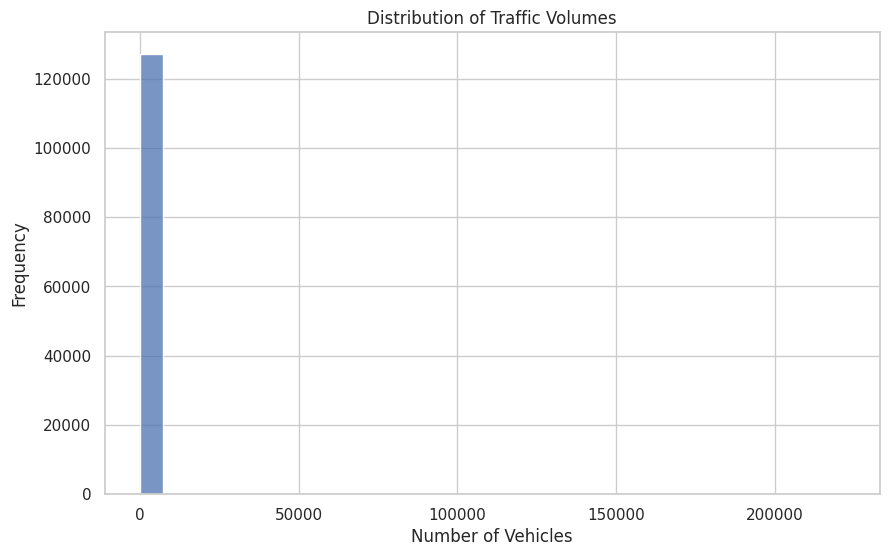

In [38]:
# Set the style of seaborn

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(traffic_data['duration_min'], kde=False, bins=30)
plt.title('Distribution of Traffic Volumes')
plt.xlabel('Number of Vehicles')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# time series plot
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")  
time_series=sns.lineplot(x=traffic_data['DateTime'],y="Vehicles",data=traffic_data, hue="Junction", palette=colors)  
time_series.set_title("DateTime vs Vehicle")  
time_series.set_ylabel("Vehicles in Number")  
time_series.set_xlabel("DateTime") 


### Create a line plot of traffic volume over time¶
.For better readability, resample the data by day and take the mean


In [ ]:
plt.figure(figsize=(14, 7))
traffic_data_resampled = traffic_data.set_index('DateTime').resample('D').mean()
sns.lineplot(data=traffic_data_resampled, x=traffic_data_resampled.index, y='Vehicles')
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Vehicles')
plt.show()


## Create boxplots to compare traffic volumes across different junctions¶


In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Junction', y='Vehicles', data=traffic_data)
plt.title('Traffic Volume by Junction')
plt.xlabel('Junction')
plt.ylabel('Number of Vehicles')
plt.show()

# years of traffic at junction


In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")  
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
count = sns.countplot(data=traffic_data, x =traffic_data["Year"], hue="Junction", palette=colors)  
count.set_title("Years of Traffic at Junctions")  
count.set_ylabel("Vehicles in numbers")  
count.set_xlabel("Date") 

# Identifying peak traffic hours and analyzing traffic patterns by the day of the week¶


In [ ]:
# Create new columns for hour of the day and day of the week

traffic_data['HourOfDay'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.day_name()


In [ ]:
# Aggregate data to find mean traffic volume for each hour of the day

hourly_traffic = traffic_data.groupby('HourOfDay')['Vehicles'].mean().reset_index()

# Aggregate data to find mean traffic volume for each day of the week

weekly_traffic = traffic_data.groupby('DayOfWeek')['Vehicles'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()


In [ ]:
# Plotting the hourly traffic volume

plt.figure(figsize=(12, 6))
sns.barplot(x='HourOfDay', y='Vehicles', data=hourly_traffic)
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.xticks(np.arange(0, 24, 1))
plt.show()

In [ ]:
# Plotting the daily traffic volume

plt.figure(figsize=(12, 6))
sns.barplot(x='DayOfWeek', y='Vehicles', data=weekly_traffic)
plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Traffic Volume')
plt.show()


# Peak Hours Identification¶
Identify peak and off-peak hours for each junction, which could be crucial for traffic management and planning.


In [ ]:
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data['Hour'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek

# Peak Hour Analysis

avg_traffic_by_hour = traffic_data.groupby('Hour')['Vehicles'].mean()
avg_traffic_by_hour.plot(kind='bar')
plt.show()



In [ ]:
# Day of the Week Analysis

avg_traffic_by_day = traffic_data.groupby('DayOfWeek')['Vehicles'].mean()
avg_traffic_by_day.plot(kind='bar')
plt.show()



In [ ]:
# Time Series Decomposition

traffic_data_daily = traffic_data.set_index('DateTime').resample('D').mean()
decomposition = seasonal_decompose(traffic_data_daily['Vehicles'], model='additive')
decomposition.plot()
plt.show()


# Time Series Decomposition¶
Decompose the traffic volume time series into trend, seasonal, and residual components to better understand underlying patterns


In [ ]:
traffic_data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')


traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data.set_index('DateTime', inplace=True)

# Resample the data to get daily averages
daily_traffic = traffic_data.resample('D').mean()

# Perform the seasonal decomposition
result = seasonal_decompose(daily_traffic['Vehicles'], model='additive', period=7)


plt.rcParams['figure.figsize'] = [12, 8]

result.plot()
plt.tight_layout()
plt.show()


# Observed:¶
This is the actual traffic volume data. The plot shows fluctuations over time, which seem to repeat in a pattern, suggesting some seasonality in the data.

-> Trend: This component shows a smoothed version of the observed data, highlighting the long-term progression or changes in traffic volume. The trend line indicates that overall traffic volume may have some periods of increase or decrease, but without more context, it's hard to draw definitive conclusions. There are some fluctuations in the trend as well, which may correspond to underlying factors affecting traffic volume over a longer period.

-> Seasonal: The seasonal component captures the regular pattern within the data that repeats over a specific period, which in this case is assumed to be weekly since the decomposition was likely done with a period of 7. The pattern is very consistent, showing peaks and troughs at regular intervals. This could correspond to higher traffic volumes on specific days of the week and lower on others, which might be associated with typical workweek patterns.

-> Residual: These are the irregularities or noise left after the trend and seasonal components have been removed from the observed data. The residuals appear to be randomly scattered around zero without any discernible pattern, which suggests that the model has captured the trend and seasonality well. However, there are a few outliers, indicating occasional deviations from the expected traffic volume that weren't explained by the trend or seasonal components.

-> Overall, the decomposition suggests that there is a strong seasonal pattern in the data, with some long-term trends and random noise. The insights from this analysis can help in forecasting traffic volumes, planning city infrastructure, and managing peak traffic times. Understanding the trend can be particularly useful for long-term planning, while the seasonal component can inform short-term operational decisions, such as traffic light coordination and congestion management strategies

## Correlation Analysis
Examine if there's a correlation between time of day or specific days and traffic volumes


In [ ]:
traffic_data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')

# Convert 'DateTime' to datetime and create new time-related features
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data['HourOfDay'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek  # Monday=0, Sunday=6

# Calculate the correlation matrix
correlation_matrix = traffic_data[['HourOfDay', 'DayOfWeek', 'Vehicles']].corr()

print(correlation_matrix)


In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Traffic Volume')
plt.show()

# Day of Week Analysis¶
Determine how traffic volumes vary by day of the week, which might reflect commuter and commercial traffic patterns


In [ ]:
traffic_data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')

traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Extract the day of the week from 'DateTime' (Monday=0, Sunday=6)
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek

# Group by 'DayOfWeek' and calculate the mean number of vehicles
average_traffic_by_day = traffic_data.groupby('DayOfWeek')['Vehicles'].mean()

# Create a mapping from day numbers to names for better readability
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
average_traffic_by_day.index = average_traffic_by_day.index.map(day_names)


plt.figure(figsize=(10, 5))
average_traffic_by_day.plot(kind='bar', color='lightgreen')
plt.title('Average Daily Traffic Volume')
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Vehicles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Holiday Effects¶
Assess how public holidays and other significant days affect traffic volumes


In [ ]:
# Sample list of public holiday dates in the 'YYYY-MM-DD' format
public_holidays = ['2016-01-01', '2016-07-04', '2016-12-25'] # as an example


public_holidays = pd.to_datetime(public_holidays)

# Mark the holidays in the traffic data
traffic_data['IsHoliday'] = traffic_data['DateTime'].dt.date.isin(public_holidays.date)

# Group by the holiday marker
holiday_traffic = traffic_data.groupby('IsHoliday')['Vehicles'].mean().reset_index()

# holiday_traffic will give you a DataFrame with average traffic volumes on holidays vs. non-holidays
# Step 1: Define a hypothetical list of public holiday dates
public_holidays = ['2016-01-01', '2016-07-04', '2016-12-25']  # Hypothetical holidays

# Convert holiday dates to datetime
public_holidays = pd.to_datetime(public_holidays)

# Step 2: Create a holiday indicator in the traffic data
traffic_data['IsHoliday'] = traffic_data['DateTime'].dt.normalize().isin(public_holidays)

# Step 3: Calculate the average traffic volumes for holidays and non-holidays
holiday_traffic = traffic_data.groupby('IsHoliday')['Vehicles'].mean()

# Step 4: Visualization
holiday_traffic.plot(kind='bar')
plt.title('Average Traffic Volume: Holidays vs. Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Average Traffic Volume')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.show()


# Long-term Trends¶
Analyze if there is a long-term increase or decrease in traffic volumes, which could be indicative of urban development or changes in population density


In [ ]:
traffic_data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Resample the data to get monthly averages
traffic_data.set_index('DateTime', inplace=True)
monthly_traffic = traffic_data.resample('M').mean()

# Plot the monthly traffic volume
monthly_traffic['Vehicles'].plot(title='Monthly Average Traffic Volume')
plt.ylabel('Average Number of Vehicles')
plt.show()

# Linear Regression for Trend Analysis

X = np.arange(len(monthly_traffic)).reshape(-1, 1)  # Time as an independent variable
y = monthly_traffic['Vehicles'].values  # Traffic volume as the dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the trend
plt.plot(monthly_traffic.index, y, label='Actual')
plt.plot(monthly_traffic.index, trend, label='Trend', color='red')
plt.title('Trend Line for Monthly Average Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Average Number of Vehicles')
plt.legend()
plt.show()


-> The first chart shows the monthly average traffic volume over time. There is a general upward trend in traffic volumes, suggesting an increase in traffic over the months. There are some fluctuations, with a noticeable dip around October 2016, which then rises back up.

-> The second chart overlays a trend line (in red) on the actual monthly average traffic volume (in blue). The trend line is linear and indicates a clear upward trajectory, confirming that there is a long-term increase in traffic volumes over this period. This could indeed be indicative of factors such as urban development, an increase in population density, or changes in traffic patterns.

-> The upward trend suggests that traffic management strategies may need to adapt to increasing volumes. Moreover, city planners and policymakers might consider this data when making decisions about infrastructure development and public transportation planning to mitigate congestion.



In [ ]:
# To analyze long-term trends, we'll use the resampled daily mean traffic data that we created earlier
# First, let's check if it is still available in the environment.

# Check if 'traffic_data_resampled' is available and print the first few entries
try:
    print(traffic_data_resampled.head())
except NameError:
    # If not, recreate it
    traffic_data_resampled = traffic_data.set_index('DateTime').resample('D').mean()['Vehicles']
    print(traffic_data_resampled.head())


# Junction Comparison¶
Compare traffic trends between junctions to see if some are consistently busier than others or if they experience traffic volume peaks at different times.


In [ ]:
traffic_data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')

# Convert 'DateTime' to a datetime object for easier manipulation
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Group the data by 'Junction' and calculate the average 'Vehicles'
junction_comparison = traffic_data.groupby('Junction')['Vehicles'].mean().reset_index()

# Plotting the average traffic volume by junction
plt.figure(figsize=(10, 6))
plt.bar(junction_comparison['Junction'], junction_comparison['Vehicles'])
plt.title('Average Traffic Volume by Junction')
plt.xlabel('Junction')
plt.ylabel('Average Traffic Volume')
plt.xticks(junction_comparison['Junction'])
plt.show()


-> Junction 1 has the highest average traffic volume, significantly more than the other junctions. This suggests it is a major traffic hub, possibly located in a central or busy area with high vehicle flow.

-> Junctions 2 and 3 show a similar average traffic volume, which is less than half of that observed in Junction 1. These junctions might serve less dense areas or could be feeder roads to the main junctions.

-> Junction 4 has the lowest average traffic volume among the four, which may indicate it is the least busy or may serve an area with lower traffic demand.

-> From a city planning and traffic management perspective, Junction 1 might require more attention in terms of traffic signal timing, congestion management strategies, or infrastructure improvements. Additionally, the differences in traffic volume could be due to various factors such as location, nearby amenities, road size, and connectivity to other parts of the city.

-> It would also be insightful to examine the variability of traffic at different times of the day for each junction to see if some are consistently busier than others during specific periods. This could be done by creating a heatmap or a multi-line plot that shows traffic volumes throughout the day for each junction.

### Let's focus on junction comparison
We will group the data by Junction and calculate the average traffic volume for each junction


In [ ]:
avg_traffic_by_junction = traffic_data.groupby('Junction')['Vehicles'].mean()
avg_traffic_by_junction

In [ ]:
traffic_data= pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')
traffic_data

In [ ]:
traffic_data=pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')

traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Set the 'DateTime' column as the index
traffic_data.set_index('DateTime', inplace=True)

# Resample the data by day to get the total number of vehicles per day
daily_traffic = traffic_data.resample('D').sum()

# Calculate the Z-scores for the daily traffic volume
daily_traffic['Z-Score'] = zscore(daily_traffic['Vehicles'])

# Define a threshold for identifying outliers
threshold = 2

# Identify outliers
outliers = daily_traffic[(daily_traffic['Z-Score'] > threshold) | (daily_traffic['Z-Score'] < -threshold)]

# Display the outliers
print(outliers)

-> Junction: This is likely a sum of junction identifiers for each day, which may not be meaningful if junctions are coded as 1, 2, 3, etc. Usually, you would not sum categorical identifiers like this.
-> Vehicles: This represents the total number of vehicles observed across all junctions for each day. It seems to be summed up over the day.
-> ID: This could be a sum of unique identifiers for each observation in a day, which also may not be meaningful as IDs are typically unique to each data entry and not intended to be aggregated.
-> Z-Score: This is the number of standard deviations away from the mean daily traffic volume. A Z-Score above 3 or below -3 is typically considered an outlier. In your output, the Z-Scores are all above 2 but below 3, suggesting these points are not extreme outliers but are still notably higher than the average traffic volume.
Looking at the DateTime index, the dates with higher Z-Scores could correspond to days when traffic was significantly higher than usual. For instance, all the dates with Z-Scores provided are above 2, meaning they are more than two standard deviations above the mean traffic volume, which could indicate unusual traffic activity.
##### To interpret these results in context, one would need to investigate what was happening on these specific dates. For example:

1. Was there a special event (like a concert or sports game) that caused a temporary spike in traffic?
Could there have been construction or detours that rerouted traffic through these junctions on those days?
2. Is there a seasonal pattern where certain times of the year consistently see increased traffic (like holiday periods or major local events)?
3. The Junction column being a constant value (240) across all listed dates suggests that the data might have been aggregated over the same number of junctions each day, or it could imply a data processing error. The ID column, if it represents a sum of unique IDs, does not provide useful analytical value and could be ignored for the purposes of outlier analysis.


In [ ]:
# Check if 'DateTime' is already the index to avoid the KeyError

if not isinstance(traffic_data.index, pd.DatetimeIndex):
    traffic_data.set_index('DateTime', inplace=True)

# Now, resample the data by day to get the total number of vehicles per day
daily_traffic = traffic_data.resample('D').sum()

# Calculate the Z-scores for the daily traffic volume
daily_traffic['Z-Score'] = stats.zscore(daily_traffic['Vehicles'])

# Define outliers as any data point that is more than 3 standard deviations from the mean
outliers = daily_traffic[np.abs(daily_traffic['Z-Score']) > 2]

# Display the outliers
outliers[['Vehicles', 'Z-Score']]


-> The output shows the days where the total daily traffic volume was notably higher than average but not extreme enough to be classified as outliers according to the common statistical threshold of 3 standard deviations.

###### Here's an analysis of the given output:

-> The DateTime column represents the dates where higher traffic volumes were recorded.
The Vehicles column shows the total number of vehicles observed on those dates.
The Z-Score column indicates how many standard deviations away from the mean daily traffic volume these values are.
All the Z-Scores are above 2, which means these data points are more than two standard deviations higher than the average, but they do not exceed the threshold of 3 standard deviations that is typically used to define an outlier. This could suggest several things:

# Moderate Unusual Activity:
These could be days with higher than usual traffic but not so extreme as to be considered outliers. This might be due to events or conditions that increase traffic volumes, such as local events, construction work, or perhaps even changes in traffic patterns like rerouting.

# Potential Data Errors:

If the traffic data is not expected to have such variations, the high values could be due to errors in data collection or processing. However, this seems less likely given the multiple occurrences.
# Threshold Sensitivity:

The threshold of 3 standard deviations is quite conservative. These points could be considered outliers in a more sensitive analysis, which could use a lower threshold like 2.5 or even 2 standard deviations.

Seasonal or Weekly Patterns: The dates are clustered in February, April, and then from early June to the end of June. This may indicate a seasonal pattern or a recurring weekly pattern (like increased traffic on certain days of the week).

To further understand these results, one would need to correlate these dates with external information, such as local events, weather conditions, or known traffic disruptions, to determine the potential causes of increased traffic volumes. If this information correlates with the dates of high Z-Scores, it could explain the increased traffic volumes. Additionally, if these dates align with specific days of the week, such as weekends or Mondays, it could point towards weekly traffic patterns.


In [ ]:
weather_data = pd.read_csv('/kaggle/input/weather-data-nov-2015/weather_data_filtered.csv')
traffic_data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')


In [ ]:
weather_data

In [ ]:
weather_data=weather_data.rename(columns={'utc_timestamp': 'DateTime'})


In [ ]:
traffic_data

In [ ]:
print(traffic_data['DateTime'].head())
print(weather_data['DateTime'].head())


In [ ]:
# Convert the 'DateTime' columns in both datasets to pandas datetime objects
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Make sure 'utc_timestamp' is a datetime object and remove timezone information
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime']).dt.tz_localize(None)

# Select the relevant weather columns for Germany
weather_data_de = weather_data[['DateTime', 'DE_temperature']]

# Merge the datasets on the timestamp fields
combined_data = pd.merge_asof(traffic_data.sort_values('DateTime'),
                              weather_data_de.sort_values('DateTime'),
                              left_on='DateTime', right_on='DateTime',
                              direction='nearest')



# Correlation analysis
correlation_matrix = combined_data[['Vehicles', 'DateTime']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

# Scatter plot of temperature vs traffic volume
sns.scatterplot(data=combined_data, x='DE_temperature', y='Vehicles')
plt.show()


Heatmap: It shows a weak positive correlation (0.27) between DE_timestamp and Vehicles. The correlation coefficient indicates there is a slight positive relationship between the time and the number of vehicles, meaning as time progresses, there is a tendency for the number of vehicles to increase slightly. However, this relationship is not strong.

Scatter Plot: The scatter plot visualizes individual data points with respect to DE_temperature (presumed on the x-axis) and the number of Vehicles (on the y-axis).There is no clear pattern or relationship visualized between the temperature and the number of vehicles, indicating that temperature alone may not be a strong predictor of traffic volume.




# ADF
In statistics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.

The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.


In [ ]:
def adf_check(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

# Apply the function on time series data
adf_check(traffic_data['Vehicles'])


In [ ]:
traffic_data['Vehicles_diff'] = traffic_data['Vehicles'] - traffic_data['Vehicles'].shift(1)
adf_check(traffic_data['Vehicles_diff'].dropna())

In [ ]:
plot_acf(traffic_data['Vehicles_diff'].dropna())
plot_pacf(traffic_data['Vehicles_diff'].dropna())


# Impact of External Factors¶
Look for external factors that may impact traffic volume, like nearby construction projects or new traffic regulations


In [ ]:
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data_daily = traffic_data.set_index('DateTime').resample('D').mean()

# Calculate the Z-score for each day's traffic volume
traffic_data_daily['z_score'] = (traffic_data_daily['Vehicles'] - traffic_data_daily['Vehicles'].mean()) / traffic_data_daily['Vehicles'].std()

# Identify days where the Z-score is above a certain threshold (e.g., 2 or -2 for significant anomalies)
anomalies = traffic_data_daily[abs(traffic_data_daily['z_score']) > 2]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(traffic_data_daily.index, traffic_data_daily['Vehicles'], label='Daily Traffic Volume')
plt.scatter(anomalies.index, anomalies['Vehicles'], color='red', label='Anomalies')
plt.xlabel('Date')
plt.ylabel('Average Daily Traffic Volume')
plt.title('Traffic Volume Over Time with Anomalies')
plt.legend()
plt.show()


-> The chart provided is a line graph that represents average daily traffic volume over time, with specific anomalies highlighted in red. Here's an analysis of the chart
# Trend
The traffic volume shows fluctuations over time with what appears to be a slight upward trend towards the right side of the graph. This could indicate a general increase in traffic volume over the period shown.
# Seasonality
There are regular patterns that suggest seasonality in the data. For example, there may be consistent peaks and troughs that correspond to certain times of the year, such as holidays or seasonal events.
# Anomalies
The red dots represent days that have been identified as anomalies, where the traffic volume was significantly different from the norm. These could be days with exceptionally high or low traffic volume compared to the average on other days.
# Potential External Factors
The anomalies could be due to external factors such as road closures, construction projects, accidents, events, or changes in traffic regulations. These would need to be investigated by cross-referencing the dates of the anomalies with external event data.
# Data Range
The data appears to cover a time span from November 2015 to July 2017.
# Low Traffic Volume Periods
The chart shows several instances, particularly early in the timeline, where the traffic volume dips significantly below the average. These could be due to sensor malfunctions, data collection issues, or real-world events that drastically reduced traffic flow.
# High Traffic Volume Periods
There are also several peak anomalies towards the latter part of the timeline, suggesting days when traffic was unusually high. These could correspond to specific events or changes in the area affecting traffic patterns.

In summary, the chart provides a visual representation of traffic volume trends and anomalies over time, which can be used to infer the impact of external factors on traffic patterns

# Check for Missing Data


In [ ]:
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data = traffic_data.sort_values(by='DateTime')

# Check for missing timestamps
expected_timestamps = pd.date_range(start=traffic_data['DateTime'].min(), 
                                    end=traffic_data['DateTime'].max(), 
                                    freq='H')
missing_timestamps = expected_timestamps.difference(traffic_data['DateTime'])


# Consistency of Data Reporting


In [ ]:
# Check the number of records per junction
records_per_junction = traffic_data['Junction'].value_counts()

# Check for irregular time intervals
time_diffs = traffic_data.groupby('Junction').apply(lambda x: x['DateTime'].diff().unique())


# Analyze Time Range for Each Junction


In [ ]:
# Get the time range for each junction
time_range_per_junction = traffic_data.groupby('Junction')['DateTime'].agg(['min', 'max'])


# Outlier Detection


In [ ]:
# Detecting outliers in 'Vehicles' column
Q1 = traffic_data['Vehicles'].quantile(0.25)
Q3 = traffic_data['Vehicles'].quantile(0.75)
IQR = Q3 - Q1
outliers = traffic_data[(traffic_data['Vehicles'] < (Q1 - 1.5 * IQR)) | (traffic_data['Vehicles'] > (Q3 + 1.5 * IQR))]
# Step 1: Print Missing Timestamps
print("Missing Timestamps:")
print(missing_timestamps)

# Step 2: Print Records Per Junction and Time Intervals
print("\nRecords per Junction:")
print(records_per_junction)
print("\nTime Intervals:")
print(time_diffs)

# Step 3: Print Time Range for Each Junction
print("\nTime Range for Each Junction:")
print(time_range_per_junction)

# Step 4: Print and Visualize Outliers
print("\nOutliers in Vehicle Counts:")
print(outliers)

# Visualizing Outliers with a Boxplot
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=traffic_data['Vehicles'])
plt.title('Boxplot of Vehicles Count')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Read the traffic data
traffic_data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')

# Feature Engineering
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data['HourOfDay'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek

# Encode categorical variable 'Junction'
traffic_data = pd.get_dummies(traffic_data, columns=['Junction'], drop_first=True)

# Define features and target
features = ['HourOfDay', 'DayOfWeek', 'Junction_2', 'Junction_3', 'Junction_4']
target = 'Vehicles'

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_data, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(train_data[features], train_data[target])

# Model Prediction
predictions = model.predict(test_data[features])

# Model Evaluation
mae = mean_absolute_error(test_data[target], predictions)
print(f'Mean Absolute Error: {mae}')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assume 'traffic_data' is your DataFrame

# Define features and target
features = ['HourOfDay', 'DayOfWeek', 'Junction_2', 'Junction_3', 'Junction_4']
target = 'Vehicles'

# Set a threshold to classify as high or low traffic
threshold = 10  # You can adjust this threshold based on your problem

# Create a binary target variable
traffic_data['TrafficLevel'] = (traffic_data[target] > threshold).astype(int)

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_data, test_size=0.3, random_state=42)

# Separate features and target in the training and testing sets
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']

# Train a random forest classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
classification_report_str = classification_report(y_test, predictions)

# Print the metrics
print(f'Accuracy: {accuracy:.2%}')
print('Classification Report:')
print(classification_report_str)

In [ ]:
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier

# Assume 'classifier' is your trained RandomForestClassifier
# Assume 'features' is a list of feature names used in training the model

def predict_traffic_level(input_date, hour_of_day, junction):
    # Convert input_date to a datetime object
    input_datetime = datetime.strptime(input_date, '%Y-%m-%d %H:%M:%S')
    
    # Determine the day of the week (Monday is 0, Sunday is 6)
    day_of_week = input_datetime.weekday()
    
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'HourOfDay': [hour_of_day],
        'DayOfWeek': [day_of_week],
        'Junction_2': [1 if junction == 2 else 0],
        'Junction_3': [1 if junction == 3 else 0],
        'Junction_4': [1 if junction == 4 else 0]
    })
    
    # Make a prediction using the trained classifier
    traffic_level = classifier.predict(input_data[features])[0]
    
    # Interpret the predicted traffic level
    if traffic_level == 0:
        return 'Low Traffic'
    elif traffic_level == 1:
        return 'High Traffic'
    else:
        return 'Unknown'

# Example usage
input_date = '2023-01-01 14:00:00'
hour = 14  # Example hour of the day
junction = 1  # Example junction

predicted_traffic_level = predict_traffic_level(input_date, hour, junction)
print(f'Predicted Traffic Level: {predicted_traffic_level}')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assume 'traffic_data' is your DataFrame

# Define features and target
features = ['HourOfDay', 'DayOfWeek', 'Junction_2', 'Junction_3', 'Junction_4']
target = 'Vehicles'

# Set a threshold to classify as high or low traffic
threshold = 10  # You can adjust this threshold based on your problem

# Create a binary target variable
traffic_data['TrafficLevel'] = (traffic_data[target] > threshold).astype(int)

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_data, test_size=0.3, random_state=42)

# Separate features and target in the training and testing sets
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']

# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_classification_report = classification_report(y_test, dt_predictions)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions)

# Train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_classification_report = classification_report(y_test, svm_predictions)

# Train a k-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_classification_report = classification_report(y_test, knn_predictions)

# Train a Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_classification_report = classification_report(y_test, lr_predictions)

# Train a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
gb_predictions = gb_classifier.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_classification_report = classification_report(y_test, gb_predictions)

# Print the metrics for each classifier
print('Decision Tree Classifier:')
print(f'Accuracy: {dt_accuracy:.2%}')
print('Classification Report:')
print(dt_classification_report)

print('\nRandom Forest Classifier:')
print(f'Accuracy: {rf_accuracy:.2%}')
print('Classification Report:')
print(rf_classification_report)

print('\nSupport Vector Machine (SVM) Classifier:')
print(f'Accuracy: {svm_accuracy:.2%}')
print('Classification Report:')
print(svm_classification_report)

print('\nk-Nearest Neighbors (KNN) Classifier:')
print(f'Accuracy: {knn_accuracy:.2%}')
print('Classification Report:')
print(knn_classification_report)

print('\nLogistic Regression Classifier:')
print(f'Accuracy: {lr_accuracy:.2%}')
print('Classification Report:')
print(lr_classification_report)

print('\nGradient Boosting Classifier:')
print(f'Accuracy: {gb_accuracy:.2%}')
print('Classification Report:')
print(gb_classification_report)

# Deep LEarning Model 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


import statsmodels.api as sm
import statsmodels.formula.api as smf           
import statsmodels.tsa.api as smt
import scipy.stats as scs
from statsmodels.graphics.api import qqplot

from itertools import product 
from tqdm.notebook import tqdm

In [ ]:
# load the dataset
traffic_data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')
traffic_data.head()


In [ ]:
# convert to datetime type
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# set datetime to index
traffic_data.set_index('DateTime',inplace=True)


Choose a small subset of the dataset to work with. (e.g. Junction 1 data)



In [ ]:
junc1 = traffic_data[traffic_data['Junction']==1]
junc1.head()


In [ ]:
junc1.shape

In [ ]:
junc1['Vehicles'].plot()


In [ ]:
# resample the data as daily average
daily_junc1 = junc1.Vehicles.resample('D').mean()

In [ ]:
daily_junc1.shape

In [ ]:
daily_junc1.plot()

In [ ]:
# check the data distribution
daily_junc1.hist()


The helper function def generate_sequence and the pytorch dataset class SequenceDataset are slightly modified from the code at https://towardsdatascience.com/time-series-forecasting-with-deep-learning-in-pytorch-lstm-rnn-1ba339885f0c

In [ ]:
# Defining a function that creates sequences and targets 
def generate_sequences(ts: pd.Series, tw: int, pw: int):
    '''
    df: Pandas Series of the univariate time-series
    tw: Training Window - Integer defining how many steps to look back
    pw: Prediction Window - Integer defining how many steps forward to predict

    returns: dictionary of sequences and targets for all sequences
    '''
    data = dict() # Store results into a dictionary
    L = len(ts)
    for i in range(L-tw):
        # Get current sequence  
        sequence = ts[i:i+tw].values
        sequence = np.reshape(sequence, (len(sequence),-1))
        # Get values right after the current sequence
        target = ts[i+tw:i+tw+pw].values
        target = np.reshape(target, (len(target),-1))
        data[i] = {'sequence': sequence, 'target': target}
    return data


In [ ]:
class SequenceDataset(Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)
# we are using 7 sequences to predict the next 1 value
lookback = 7 #training window
n_pred = 1 #prediction window


In [ ]:
sequences = generate_sequences(daily_junc1, lookback, n_pred)

In [ ]:

len(sequences) # sanity check, should be len(data) - lookback = 608 - 7

In [ ]:
dataset = SequenceDataset(sequences)



In [ ]:
split = 0.67 # Train/Test Split ratio


In [ ]:
train_len = int(len(dataset)*split)


In [ ]:
lens = [train_len, len(dataset)-train_len]
lens

In [ ]:
# random split of dataset into train and test set
r_train_ds, r_test_ds = random_split(dataset, lens)

# sequential split of dataset into train and test set 
s_train_ds = Subset(dataset, range(lens[0]))
s_test_ds = Subset(dataset, range(lens[0],lens[0]+lens[1]))

BATCH_SIZE = 8 # Training batch size

# create dataloaders
r_trainloader = DataLoader(r_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
r_testloader = DataLoader(r_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# create dataloaders
s_trainloader = DataLoader(s_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_testloader = DataLoader(s_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# reshape the data to be used as an input for LSTM
daily_junc1_ts = daily_junc1.values.astype('float32')
daily_junc1_ts = np.reshape(daily_junc1_ts, (len(daily_junc1_ts),-1))


# Model: LSTM¶


In [ ]:
# define a simple LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size #output size
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 32) #fully connected 1
        self.fc = nn.Linear(32, output_size) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #cell state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        #output = output[:,-1,:] # when using the last element of the output
        #hn = hn.view(-1, self.hidden_size) # when using the hidden state for forecasting
        out = self.relu(output)
        #out = self.relu(hn) # when using the hidden state for forecasting
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out) 
        return out


In [ ]:
input_size = 1 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

output_size = 1 #output size


In [ ]:
r_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback) #our lstm class 
num_epochs = 100 
learning_rate = 0.01
# define an optimizer, loss function, and data loader
r_optimizer = optim.Adam(r_model.parameters())
loss_fn = nn.MSELoss()
summary(r_model, input_size=(1, 7, 1))


In [ ]:
t_losses = []

for epoch in range(num_epochs):    
    
    train_loss = 0.0
    
    r_model.train()
    
    for X_batch, y_batch in r_trainloader:
        r_optimizer.zero_grad()    
        
        y_pred = r_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()
                
        loss.backward()
        r_optimizer.step()
    epoch_loss = train_loss / len(r_trainloader)
    t_losses.append(epoch_loss)

    if epoch % 10 != 0:
        continue
            
    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))

In [ ]:
s_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback)
s_optimizer = optim.Adam(s_model.parameters())
loss_fn = nn.MSELoss()


In [ ]:
t_losses = []

for epoch in range(num_epochs):    
    
    train_loss = 0.0
    
    s_model.train()
    
    for X_batch, y_batch in s_trainloader:
        s_optimizer.zero_grad()    
        y_pred = s_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()
                
        loss.backward()
        s_optimizer.step()
    epoch_loss = train_loss / len(s_trainloader)
    t_losses.append(epoch_loss)

    if epoch % 10 != 0:
        continue
            
    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))


In [ ]:
unshuffled_dataloader= DataLoader(dataset,shuffle=False)


The following helper functions def make_predictions_from_dataloader, def one_step_forecast, def n_step_forecast are slightly modified from the code in https://towardsdatascience.com/time-series-forecasting-with-deep-learning-in-pytorch-lstm-rnn-1ba339885f0c



In [ ]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
    model.eval()
    predictions, actuals = [], []
    for x, y in unshuffled_dataloader:
        with torch.no_grad():
            p = model(x)
            p = p[:,-1,:]
            predictions.append(p)
            actuals.append(y)
            #actuals.append(y.squeeze())
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions, actuals.squeeze()


In [ ]:
r_preds, actuals = make_predictions_from_dataloader(r_model, unshuffled_dataloader)


In [ ]:
s_preds, actuals = make_predictions_from_dataloader(s_model, unshuffled_dataloader)


In [ ]:
def one_step_forecast(model, history):
    '''
    model: PyTorch model object
    history: a sequence of values representing the latest values of the time 
    series, requirement -> len(history.shape) == 2
    
    outputs a single value which is the prediction of the next value in the
    sequence.
    '''
    model.eval()
    with torch.no_grad():
        pre = torch.Tensor(history).unsqueeze(0)
        pred = model(pre)
        pred = pred[:,-1,:]
    return pred.detach().numpy().reshape(-1)


In [ ]:
forecast = one_step_forecast(r_model, daily_junc1_ts)
forecast

In [ ]:
def n_step_forecast(data, model, lookback: int, n: int, forecast_from: int=None):
    '''
    n: integer defining how many steps to forecast
    forecast_from: integer defining which index to forecast from. None if
    you want to forecast from the end.
    plot: True if you want to output a plot of the forecast, False if not.
    '''
    history = data.copy()
      
    # Create initial sequence input based on where in the series to forecast 
    # from.
    if forecast_from:
        pre = list(history[forecast_from - lookback : forecast_from])
    else:
        pre = list(history)[-lookback:]

    # Call one_step_forecast n times and append prediction to history
    for i, step in enumerate(range(n)):
        pre_ = np.array(pre[-lookback:]).reshape(-1, 1)
        forecast = one_step_forecast(model, pre_)
        #forecast = forecast[:,-1,:]
        pre.append(forecast)
      
    # The rest of this is just to add the forecast to the correct time of 
    # the history series
    res = history.copy()
    ls = [np.nan for i in range(len(history))]

    # Note: I have not handled the edge case where the start index + n is 
    # before the end of the dataset and crosses past it.
    if forecast_from:
        ls[forecast_from : forecast_from + n] = list(np.array(pre[-n:]))
        res['forecast'] = ls
        res.columns = ['actual', 'forecast']
    else:
        fc = ls + list(np.array(pre[-n:]))
        ls = ls + [np.nan for i in range(len(pre[-n:]))]
        ls[:len(history)] = history
        res = pd.DataFrame([ls, fc], index=['actual', 'forecast']).T
        forecast = res.forecast[-n:]
        forecast.index = pd.date_range('2017-07-01', periods=n, freq='D')

    #return res
    return forecast


In [ ]:
r_lstm_forecast = n_step_forecast(daily_junc1_ts, r_model, lookback=7, n=30)
r_lstm_forecast


In [ ]:
s_lstm_forecast = n_step_forecast(daily_junc1_ts, s_model, lookback=7, n=30)
s_lstm_forecast

In [ ]:
lstm_forecast = n_step_forecast(daily_junc1_ts, s_model, lookback=7, n=30)
lstm_forecast

In [ ]:
# helper function to prepare modeled results
def prepare_results(model, preds, data, lookback):
    
    sample_plot = np.ones_like(data) * np.nan
    sample_plot[lookback:] = preds
    sample_df = pd.DataFrame(sample_plot, index=daily_junc1.index)
    return sample_df
r_modeled = prepare_results(r_model, r_preds, daily_junc1_ts, lookback=7)
r_modeled


In [ ]:
s_modeled = prepare_results(s_model, s_preds, daily_junc1_ts, lookback=7)
s_modeled

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [ ]:
# helper function to plot all the results for comparison
def plot_results(original, modeled, forecast): 
    """ Given 
        original: a time series with datetime index
        modeled: model fitted values
        forecast: inferenced values
        
        Plot the original time series and the prediction of the test set
    """

    # calculate RMSE values between the original and modeled
    error = root_mean_squared_error(original[train_len+lookback+1:],modeled[train_len+lookback+1:])

    # plot
    plt.figure(figsize=(15, 7))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(original, c='b', label="actual")
    plt.plot(modeled, c='r', label="modeled")
    plt.plot(forecast, color='r', label="forecast")
    plt.axvspan(original.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.legend()
    plt.grid(True);


In [ ]:
plot_results(daily_junc1, r_modeled, r_lstm_forecast)


In [ ]:
plot_results(daily_junc1, s_modeled, s_lstm_forecast)


# Model: SARIMA¶


In [ ]:
# helper function to check Dickey-Fuller test results, ACF, and PACF
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


In [ ]:
# setting initial values and some bounds for them
ps = range(1, 3)
d=1 
qs = range(1, 3)
Ps = range(1, 3)
D=1 
Qs = range(1, 3)
s = 7 # season length 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(daily_junc1, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table


In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


In [ ]:
result_table.head()


In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(daily_junc1, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

In [ ]:
tsplot(best_model.resid[7+1:], lags=30)

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    #data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    forecast = pd.concat([data['sarima_model'], forecast])

    # calculate error, again having shifted on s+d steps from the beginning
    #error = mean_absolute_percentage_error(data[s+d:-1].values, data['sarima_model'][s+d:].values)
    error = root_mean_squared_error(data[s+d:-1].values, data['sarima_model'][s+d:].values)

    plt.figure(figsize=(15, 7))
    #plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-2], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(daily_junc1, label="actual")
    plt.legend()
    plt.grid(True);


In [ ]:
#plotSARIMA(daily_junc1, best_model, 30)


In [ ]:
sarima_forecast = best_model.predict(start = daily_junc1.shape[0], end = daily_junc1.shape[0]+30)
sarima_forecast

In [ ]:
best_model.plot_diagnostics(figsize=(15, 10))
plt.show()